## EVD transmission model from Khan et al 2015 using Python/PyGOM

Author: Thomas Finnie @twomagpi

Date: 2018-10-03

In [1]:
# housekeeping
import numpy
from pygom import DeterministicOde, TransitionType, SimulateOde, Transition

In [2]:
# first set up the states
states = ['Susceptible_lr',
          'Susceptible_hr',
          'Exposed', 
          'Infected', 
          'Hospitalized',
          'Recovered'
        ]

**Table 1**

|Parameter|Description|Value|
|:--------|:----------|:---:|
|$\phi_H$ |Modification parameter for infection rate of high-risk susceptible individuals | 1.2-2|
|$\sigma_I$ |Disease-induced death rate of infected individuals | 0.10|
|$\sigma_H$ |Disease-induced death rate of hospitalized individuals | 0.5|
|$\theta_I$ |Recovery rate of infected individuals | 0.1|
|$\theta_H$ |Recovery rate of hospitalized individuals | 0.2|
|$\alpha$   |Rate at which latent individuals become infectious | 0.1|
|$\tau$|	Hospitalization rate for infected individuals | 0.16|
|$\Pi$|	Recruitment rate | 1.7|
|p|	Fraction of the individuals at high-risk |	0.2|
|$\beta$|	Transmission rate of disease | Estimated|
|$1/\mu$|	Average life of human | 63 years|

In [3]:
# now set up the parameters
parameters = ['phi_H',
              'sigma_I',
              'sigma_H',
              'theta_I',
              'theta_H',
              'alpha',
              'tau',
              'Rec_rate',
              'p',
              'beta',
              'mu',
              'lda',
              'eta',
              'N'
             ]

In [4]:
# Set this up as birth, death and transitions 
# This could have been done as lifts of the ODE system from the paper but
# being more verbose like this makes us concentrate on the model
transitions = [
               Transition(origin='Susceptible_lr',
                          destination='Exposed',
                          equation='lda*Susceptible_lr',
                          transition_type=TransitionType.T),
               Transition(origin='Susceptible_hr',
                          destination='Exposed',
                          equation='phi_H * lda * Susceptible_hr',
                          transition_type=TransitionType.T),
               Transition(origin='Exposed',
                          destination='Infected',
                          equation='alpha * Exposed',
                          transition_type=TransitionType.T),
               Transition(origin='Infected',
                          destination='Hospitalized',
                          equation='tau * Infected',
                          transition_type=TransitionType.T),
               Transition(origin='Infected',
                          destination='Recovered',
                          equation='theta_I * Infected',
                          transition_type=TransitionType.T),
               Transition(origin='Hospitalized',
                          destination='Recovered',
                          equation='theta_H * Infected',
                          transition_type=TransitionType.T),
              ]

births_deaths = [
                # Births first
                Transition(origin='Susceptible_lr',
                           equation='Rec_rate * (1 - p)',
                           transition_type=TransitionType.B),
                Transition(origin='Susceptible_hr',
                           equation='Rec_rate * p',
                           transition_type=TransitionType.B),
                # Natural Deaths
                Transition(origin='Susceptible_lr',
                           equation='mu * Susceptible_lr',
                           transition_type=TransitionType.D),
                Transition(origin='Susceptible_hr',
                           equation='mu * Susceptible_hr',
                           transition_type=TransitionType.D),
                Transition(origin='Exposed',
                           equation='mu * Exposed',
                           transition_type=TransitionType.D),
                Transition(origin='Infected',
                           equation='mu * Infected',
                           transition_type=TransitionType.D),
                Transition(origin='Hospitalized',
                           equation='mu * Hospitalized',
                           transition_type=TransitionType.D),
                Transition(origin='Recovered',
                           equation='mu * Recovered',
                           transition_type=TransitionType.D),
                #disease deaths
                Transition(origin='Infected',
                           equation='sigma_I * Infected',
                           transition_type=TransitionType.D),
                Transition(origin='Hospitalized',
                           equation='sigma_H * Hospitalized',
                           transition_type=TransitionType.D)
]

derived_parameters = [('lda', 'beta * ((Infected + (eta*Hospitalized))/N)'),
                      ('N', 'Susceptible_lr + Susceptible_hr + Exposed + Infected + Hospitalized + Recovered')]

In [5]:
# build the model system
model_system = DeterministicOde(states, 
                                parameters,
                                transition=transitions,
                                birth_death=births_deaths,
                                derived_param=derived_parameters
                               )
model_system.print_ode()

⎡                                  -(Susceptibleₗᵣ⋅β⋅(Hospitalized⋅η + Infecte
⎢dSusceptible_lr/dt=               ───────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                     -Susceptibleₕᵣ⋅β⋅φ_H⋅(Hospitalized⋅η + I
⎢dSusceptible_hr/dt=                  ────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                     -Exposed⋅(α + μ)⋅(Exposed + Hospitalized + Infected + Re
⎢   dExposed/dt=      ────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢   dInfected/dt=                                   

In [6]:
# Create the timeline
t = numpy.linspace(0, 200, 200)
# Set the inital values for the states
model_system.initial_values = ([1000000, 
                                20000, 
                                15, 
                                10, 
                                0, 
                                0], 
                                t[0])

In [7]:
liberia_parameters = {
    'phi_H': 1.6,
    'sigma_I': 0.1,
    'sigma_H': 0.5,
    'theta_I': 0.1,
    'theta_H': 0.2,
    'alpha': 0.1,
    'tau': 0.16,
    'Rec_rate': 1.7,
    'p': 0.2,
    'beta': 0.371,
    'mu': (1/63)/365,
    'eta': 0.7,
}
sierra_leone_parameters = {
    'phi_H': 1.6,
    'sigma_I': 0.1,
    'sigma_H': 0.5,
    'theta_I': 0.1,
    'theta_H': 0.2,
    'alpha': 0.1,
    'tau': 0.16,
    'Rec_rate': 1.7,
    'p': 0.2,
    'beta': 0.371,
    'mu': (1/63)/365,
    'eta': 0.7,
}

In [8]:
model_system.parameters = liberia_parameters
solution,output = model_system.integrate(t[1::], full_output=True)
model_system.plot()

<Figure size 640x480 with 6 Axes>

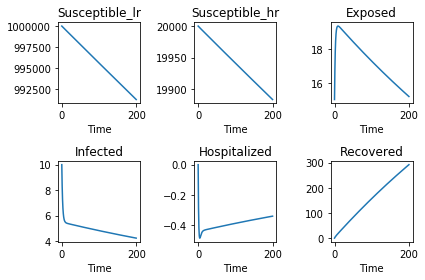

In [9]:
model_system.parameters = sierra_leone_parameters
solution,output = model_system.integrate(t[1::], full_output=True)
model_system.plot()